# Item-Item Collaborative Filtering

Implementation of classical similarity-based recommendation from co-rating patterns, including comparison of multiple similarity functions, optimized with fast sparse cosine similarity computation.

## 1. Imports and Data Loading

The split is temporal 75/12.5/12.5, so the model is trained on past interactions and evaluated on future ones.

In [17]:
!git clone https://$GITHUB_TOKEN@github.com/Its-OP/ucu-rs-2026.git

Cloning into 'ucu-rs-2026'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 241 (delta 35), reused 48 (delta 23), pack-reused 168 (from 1)
Receiving objects: 100% (241/241), 78.76 MiB | 33.58 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [18]:
%cd ucu-rs-2026

/content/ucu-rs-2026_old/ucu-rs-2026


We fix random seeds so initialization and shuffling behave consistently across runs, and we reduce noisy warnings/logs to keep the training output readable.

In [19]:
from __future__ import annotations

import os
import sys
import random
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt

sys.path.append(str(Path(".").resolve()))

from src.models.base import RecommenderModel, Rating
from src.eval.eval import evaluate
from data.dataframes import movies_enriched, users, train, test

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("src.eval.eval").setLevel(logging.ERROR)

In [20]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

## 2. Similarity Functions

We implement and compare three similarity measures:
- Cosine: angle between vectors, ignores magnitude
- Adjusted Cosine: centers by user mean, handles rating scale differences
- Pearson: correlation coefficient, centers by item mean

In [21]:
def cosine_similarity_matrix(R: sparse.csr_matrix) -> np.ndarray:
    R_csc = R.tocsc().astype(np.float32)

    col_sq = np.array(R_csc.power(2).sum(axis=0)).ravel() # fast column norms sqrt(sum of squares)
    norms = np.sqrt(col_sq)
    norms[norms == 0] = 1.0

    R_norm = R_csc.multiply(1.0 / norms)

    S = (R_norm.T @ R_norm).toarray().astype(np.float32)
    return S


def adjusted_cosine_similarity_matrix(R: sparse.csr_matrix) -> np.ndarray:
    R_dense = R.toarray().astype(np.float32)

    # user means
    user_sums = R.sum(axis=1).A1
    user_counts = (R > 0).sum(axis=1).A1
    user_counts[user_counts == 0] = 1
    user_means = (user_sums / user_counts).astype(np.float32)

    # center by user mean
    mask = (R_dense > 0).astype(np.float32)
    R_centered = R_dense - (user_means[:, None] * mask)

    # cosine on centered
    norms = np.linalg.norm(R_centered, axis=0)
    norms[norms == 0] = 1
    R_norm = R_centered / norms

    S = (R_norm.T @ R_norm).astype(np.float32)
    return S


def pearson_similarity_matrix(R: sparse.csr_matrix) -> np.ndarray:
    R_dense = R.toarray().astype(np.float32)

    # item means
    item_sums = R.sum(axis=0).A1
    item_counts = (R > 0).sum(axis=0).A1
    item_counts[item_counts == 0] = 1
    item_means = (item_sums / item_counts).astype(np.float32)

    # center by item mean
    mask = (R_dense > 0).astype(np.float32)
    R_centered = R_dense - (item_means * mask)

    # cosine on centered
    norms = np.linalg.norm(R_centered, axis=0)
    norms[norms == 0] = 1
    R_norm = R_centered / norms

    S = (R_norm.T @ R_norm).astype(np.float32)
    return S


SIMILARITY_FUNCTIONS = {
    "cosine": cosine_similarity_matrix,
    "adjusted_cosine": adjusted_cosine_similarity_matrix,
    "pearson": pearson_similarity_matrix,
}

## 3. Item-Item Collaborative Filtering Model


This is classical item-item collaborative filtering, where items are similar if they were rated similarly by many users. We compute an item-item similarity matrix from the user-item rating matrix and recommend items similar to what the user already liked.

We also compare three similarities:

* Cosine similarity (angle between item rating vectors)
  $$
  \text{sim}(i,j)=\frac{v_i^\top v_j}{\lVert v_i\rVert\lVert v_j\rVert}
  $$
  Implementation normalizes columns then computes $S=R^\top R$.

* Adjusted cosine (centers ratings by user mean to reduce user scale effects)
  $$
  \text{sim}(i,j)=\frac{\sum_u (r_{ui}-\bar r_u)(r_{uj}-\bar r_u)}{\sqrt{\sum_u (r_{ui}-\bar r_u)^2}\sqrt{\sum_u (r_{uj}-\bar r_u)^2}}
  $$

* Pearson (centers by item mean, correlation-like)


For each candidate item $i$, we take the user’s ratings on neighbor items and compute a weighted average:

$$
\hat{r}*{ui}=\frac{\sum*{j\in N_k(i)\cap I_u} \text{sim}(i,j),r_{uj}}{\sum_{j\in N_k(i)\cap I_u} |\text{sim}(i,j)|}
$$


Two main speedups:

1. Faster cosine norms via replacement `sparse.linalg.norm` with a manual sum of squares then sqrt for column norms, which is much faster on sparse matrices.

2. Precomputing top-k neighbors once right after building the similarity matrix, instead of searching neighbors for every user and item repeatedly. Then user scoring is mostly vectorized indexing and reductions.

In [22]:
class ItemItemCF(RecommenderModel):
    """Item-Item Collaborative Filtering with exact rating prediction.

    Predicts ratings on 1-5 scale using weighted average of similar items.
    Fully vectorized for speed.

    Parameters
    ----------
    similarity : str
        Similarity function: 'cosine', 'adjusted_cosine', or 'pearson'.
    k_neighbors : int
        Number of most similar items to use for prediction.
    """

    def __init__(
        self,
        similarity: str = "cosine",
        k_neighbors: int = 50,
    ):
        self.similarity = similarity
        self.k_neighbors = k_neighbors

        self.sim_matrix: np.ndarray | None = None
        self.R: np.ndarray | None = None
        self.global_mean: float = 3.0
        self.item_means: np.ndarray | None = None

        self.item_to_idx: Dict[int, int] = {}
        self.idx_to_item: Dict[int, int] = {}
        self.user_to_idx: Dict[int, int] = {}

    def fit(self, ratings: pd.DataFrame) -> "ItemItemCF":
        """Fit model by computing item-item similarity matrix."""
        users_list = ratings["UserID"].unique()
        items_list = ratings["MovieID"].unique()

        self.user_to_idx = {u: i for i, u in enumerate(users_list)}
        self.item_to_idx = {m: i for i, m in enumerate(items_list)}
        self.idx_to_item = {i: m for m, i in self.item_to_idx.items()}

        # sparse rating matrix
        row = ratings["UserID"].map(self.user_to_idx).values
        col = ratings["MovieID"].map(self.item_to_idx).values
        data = ratings["Rating"].values.astype(np.float32)

        R_sparse = sparse.csr_matrix(
            (data, (row, col)),
            shape=(len(users_list), len(items_list)),
            dtype=np.float32
        )

        self.R = R_sparse.toarray()

        # fallback
        self.global_mean = float(ratings["Rating"].mean())
        item_sums = R_sparse.sum(axis=0).A1
        item_counts = (R_sparse > 0).sum(axis=0).A1
        item_counts[item_counts == 0] = 1
        self.item_means = item_sums / item_counts

        # similarity matrix
        sim_func = SIMILARITY_FUNCTIONS[self.similarity]
        print(f"  Computing {self.similarity} similarity matrix...")
        self.sim_matrix = sim_func(R_sparse)

        np.fill_diagonal(self.sim_matrix, 0) # zero out self-similarity

        # top-k neighbors for each item pre-computed for speed optimization
        print(f"  Pre-computing top-{self.k_neighbors} neighbors...")
        n_items = self.sim_matrix.shape[0]
        self.top_k_neighbors = np.zeros((n_items, self.k_neighbors), dtype=np.int32)
        self.top_k_sims = np.zeros((n_items, self.k_neighbors), dtype=np.float32)

        for i in range(n_items):
            sims = self.sim_matrix[i]
            # top-k by absolute similarity
            if n_items > self.k_neighbors:
                top_idx = np.argpartition(-np.abs(sims), self.k_neighbors)[:self.k_neighbors]
            else:
                top_idx = np.arange(n_items)
            # sort by similarity descending
            sorted_order = np.argsort(-np.abs(sims[top_idx]))
            top_idx = top_idx[sorted_order[:self.k_neighbors]]

            self.top_k_neighbors[i, :len(top_idx)] = top_idx
            self.top_k_sims[i, :len(top_idx)] = sims[top_idx]

        return self

    def _predict_scores_for_user_vectorized(self, u_idx: int) -> np.ndarray:
        user_ratings = self.R[u_idx] # (n_items,)
        rated_mask = user_ratings > 0
        n_items = len(user_ratings)

        if not rated_mask.any():
            return np.full(n_items, self.global_mean, dtype=np.float32)

        # ratings of neighbors
        neighbor_ratings = user_ratings[self.top_k_neighbors] # (n_items, k)
        neighbor_sims = self.top_k_sims.copy() # (n_items, k)

        # mask unrated neighbors
        neighbor_rated = neighbor_ratings > 0
        neighbor_sims_masked = neighbor_sims * neighbor_rated

        # weighted sum scores
        numerator = np.sum(neighbor_sims_masked * neighbor_ratings, axis=1)
        denominator = np.sum(np.abs(neighbor_sims_masked), axis=1)

        scores = np.where(
            denominator > 0,
            numerator / denominator,
            self.item_means # fallback to item mean
        )

        scores = np.clip(scores, 1.0, 5.0)

        return scores.astype(np.float32)

    def predict(
        self,
        users: pd.DataFrame,
        ratings: pd.DataFrame,
        movies: pd.DataFrame,
        k: int = 10,
    ) -> Dict[int, List[Rating]]:
        ratings_by_user = {
            uid: set(grp["MovieID"].values)
            for uid, grp in ratings.groupby("UserID")
        }

        preds: Dict[int, List[Rating]] = {}

        for uid in users["UserID"].values:
            uid = int(uid)
            seen = ratings_by_user.get(uid, set())

            if uid not in self.user_to_idx:
                preds[uid] = []
                continue

            u_idx = self.user_to_idx[uid]
            scores = self._predict_scores_for_user_vectorized(u_idx)

            # mask seen items
            scores_for_ranking = scores.copy()
            for mid in seen:
                if mid in self.item_to_idx:
                    scores_for_ranking[self.item_to_idx[mid]] = -np.inf

            # top-k indices
            n_items = len(scores_for_ranking)
            valid_k = min(k, (scores_for_ranking > -np.inf).sum())
            if valid_k == 0:
                preds[uid] = []
                continue

            top_indices = np.argpartition(-scores_for_ranking, valid_k - 1)[:valid_k]
            top_indices = top_indices[np.argsort(-scores_for_ranking[top_indices])]

            preds[uid] = [
                Rating(
                    movie_id=int(self.idx_to_item[i]),
                    score=float(scores[i])
                )
                for i in top_indices
                if scores_for_ranking[i] > -np.inf
            ]

        return preds

## 4. Hyperparameter Configurations

In [23]:
CONFIGS = [
  # adjusted cosine (best so far): neighbor sweep
  {"name":"itemcf_adj_k20",  "similarity":"adjusted_cosine", "k_neighbors":20},
  {"name":"itemcf_adj_k50",  "similarity":"adjusted_cosine", "k_neighbors":50},
  {"name":"itemcf_adj_k100", "similarity":"adjusted_cosine", "k_neighbors":100},
  {"name":"itemcf_adj_k200", "similarity":"adjusted_cosine", "k_neighbors":200},

  # pearson: neighbor sweep
  {"name":"itemcf_pears_k50",  "similarity":"pearson", "k_neighbors":50},
  {"name":"itemcf_pears_k100", "similarity":"pearson", "k_neighbors":100},
  {"name":"itemcf_pears_k200", "similarity":"pearson", "k_neighbors":200},

  # cosine: just to confirm trend
  {"name":"itemcf_cos_k100", "similarity":"cosine", "k_neighbors":100},
  {"name":"itemcf_cos_k200", "similarity":"cosine", "k_neighbors":200},
]

K_VALUES = [10]
THRESHOLD = 4.0

## 5. Training and Evaluation

In [24]:
results = []
models = {}

for config in CONFIGS:
    name = config["name"]
    print(f"\nTraining: {name}")
    print(f"{'-'*30}")

    model = ItemItemCF(
        similarity=config["similarity"],
        k_neighbors=config["k_neighbors"],
    )
    model.fit(train)
    models[name] = model

    for k in K_VALUES:
        metrics = evaluate(
            model=model,
            train_ratings=train,
            test_ratings=test,
            users=users,
            movies=movies_enriched,
            k=k,
            threshold=THRESHOLD,
        )

        results.append({
            "model": name,
            "k": k,
            "ndcg": metrics.ndcg,
            "precision": metrics.precision,
            "recall": metrics.recall,
        })


Training: itemcf_adj_k20
------------------------------
  Computing adjusted_cosine similarity matrix...
  Pre-computing top-20 neighbors...

Training: itemcf_adj_k50
------------------------------
  Computing adjusted_cosine similarity matrix...
  Pre-computing top-50 neighbors...

Training: itemcf_adj_k100
------------------------------
  Computing adjusted_cosine similarity matrix...
  Pre-computing top-100 neighbors...

Training: itemcf_adj_k200
------------------------------
  Computing adjusted_cosine similarity matrix...
  Pre-computing top-200 neighbors...

Training: itemcf_pears_k50
------------------------------
  Computing pearson similarity matrix...
  Pre-computing top-50 neighbors...

Training: itemcf_pears_k100
------------------------------
  Computing pearson similarity matrix...
  Pre-computing top-100 neighbors...

Training: itemcf_pears_k200
------------------------------
  Computing pearson similarity matrix...
  Pre-computing top-200 neighbors...

Training: itemc

## 6. Results Summary

In [25]:
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df.to_string(index=False))

print("\n\nNDCG@K by Model:")
ndcg_pivot = results_df.pivot(index="model", columns="k", values="ndcg")
print(ndcg_pivot.round(4))

print("\n\nPrecision@K by Model:")
prec_pivot = results_df.pivot(index="model", columns="k", values="precision")
print(prec_pivot.round(4))

print("\n\nRecall@K by Model:")
recall_pivot = results_df.pivot(index="model", columns="k", values="recall")
print(recall_pivot.round(4))


All Results:
            model  k     ndcg  precision   recall
   itemcf_adj_k20 10 0.030249   0.029348 0.005599
   itemcf_adj_k50 10 0.021604   0.020369 0.004534
  itemcf_adj_k100 10 0.015993   0.013208 0.002379
  itemcf_adj_k200 10 0.014127   0.012037 0.001871
 itemcf_pears_k50 10 0.018297   0.017625 0.003814
itemcf_pears_k100 10 0.010727   0.009680 0.001561
itemcf_pears_k200 10 0.005734   0.004545 0.000686
  itemcf_cos_k100 10 0.006622   0.005902 0.001025
  itemcf_cos_k200 10 0.006168   0.005724 0.000861


NDCG@K by Model:
k                      10
model                    
itemcf_adj_k100    0.0160
itemcf_adj_k20     0.0302
itemcf_adj_k200    0.0141
itemcf_adj_k50     0.0216
itemcf_cos_k100    0.0066
itemcf_cos_k200    0.0062
itemcf_pears_k100  0.0107
itemcf_pears_k200  0.0057
itemcf_pears_k50   0.0183


Precision@K by Model:
k                      10
model                    
itemcf_adj_k100    0.0132
itemcf_adj_k20     0.0293
itemcf_adj_k200    0.0120
itemcf_adj_k50     0.0204
i

## 7. Similarity Function Comparison

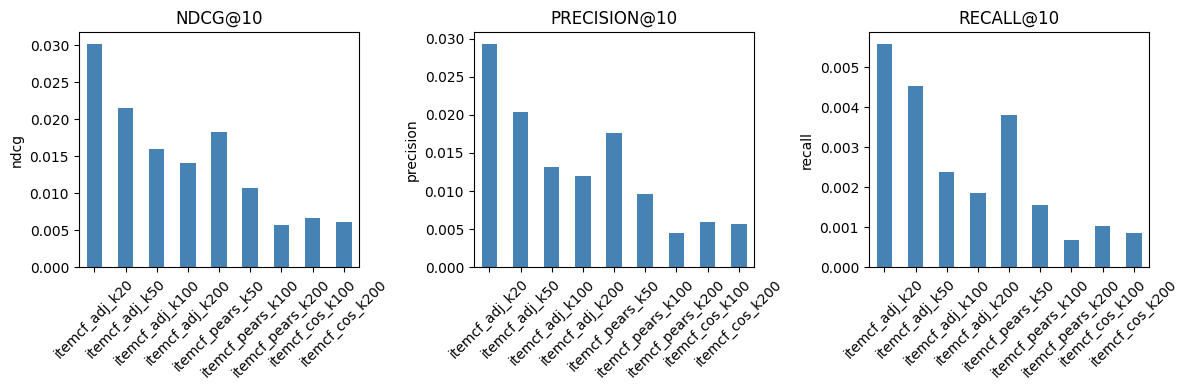

In [26]:
k10 = results_df[results_df["k"] == 10].copy()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, metric in zip(axes, ["ndcg", "precision", "recall"]):
    data = k10.set_index("model")[metric]
    data.plot(kind="bar", ax=ax, color='steelblue')
    ax.set_title(f"{metric.upper()}@10")
    ax.set_ylabel(metric)
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Best Model Selection

In [27]:
# at K=10
k10_results = results_df[results_df["k"] == 10].sort_values("ndcg", ascending=False)
print("\nModels ranked by NDCG@10:")
print(k10_results.to_string(index=False))

best_model_name = k10_results.iloc[0]["model"]
print(f"\nBest model: {best_model_name}")


Models ranked by NDCG@10:
            model  k     ndcg  precision   recall
   itemcf_adj_k20 10 0.030249   0.029348 0.005599
   itemcf_adj_k50 10 0.021604   0.020369 0.004534
 itemcf_pears_k50 10 0.018297   0.017625 0.003814
  itemcf_adj_k100 10 0.015993   0.013208 0.002379
  itemcf_adj_k200 10 0.014127   0.012037 0.001871
itemcf_pears_k100 10 0.010727   0.009680 0.001561
  itemcf_cos_k100 10 0.006622   0.005902 0.001025
  itemcf_cos_k200 10 0.006168   0.005724 0.000861
itemcf_pears_k200 10 0.005734   0.004545 0.000686

Best model: itemcf_adj_k20


## 9. Example Recommendations with Predicted Ratings

In [28]:
example_user = int(train["UserID"].value_counts().index[0])
print(f"\nExample recommendations for user {example_user}:\n")

best_model = models[best_model_name]
recs = best_model.predict(
    users=users[users["UserID"] == example_user],
    ratings=train,
    movies=movies_enriched,
    k=10
)[example_user]

rec_data = []
for i, r in enumerate(recs, 1):
    movie = movies_enriched[movies_enriched["movie_id"] == r.movie_id].iloc[0]
    rec_data.append({
        "rank": i,
        "title": movie["title"],
        "genres": movie["genres"],
        "predicted_rating": f"{r.score:.2f}"
    })

rec_df = pd.DataFrame(rec_data)
print(rec_df.to_string(index=False))


Example recommendations for user 1680:

 rank                           title                genres predicted_rating
    1              Autumn in New York         Drama|Romance             5.00
    2                  Santa Fe Trail Drama|Romance|Western             5.00
    3                 Brief Encounter         Drama|Romance             5.00
    4                Unhook the Stars                 Drama             5.00
    5 Chambermaid on the Titanic, The               Romance             5.00
    6                     Underground                   War             5.00
    7               Perez Family, The        Comedy|Romance             5.00
    8                           Klute         Drama|Mystery             5.00
    9                        Deceiver                 Crime             5.00
   10                 Grass Harp, The                 Drama             5.00


## 10. User History for Context

In [29]:
user_history = train[train["UserID"] == example_user].merge(
    movies_enriched[["movie_id", "title", "genres"]],
    left_on="MovieID",
    right_on="movie_id"
).sort_values("Rating", ascending=False)

print(f"\nUser {example_user}'s top-rated movies in training set:")
print(user_history[["title", "genres", "Rating"]].head(10).to_string(index=False))


User 1680's top-rated movies in training set:
                title                     genres  Rating
            Manhattan       Comedy|Drama|Romance       5
      Sophie's Choice                      Drama       5
     Mulholland Falls   Crime|Film-Noir|Thriller       5
     Crying Game, The          Drama|Romance|War       5
       Basic Instinct           Mystery|Thriller       5
            Chinatown Film-Noir|Mystery|Thriller       5
Bringing Out the Dead               Drama|Horror       5
                Trust               Comedy|Drama       5
     Harold and Maude                     Comedy       5
           Sting, The               Comedy|Crime       5
